In [ ]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.2 MB/s eta 0:00:00


In [ ]:
# All these are done so as to resolve certain dependency errors!
! pip install -q -U accelerate
! pip install -q -U transformers
!pip install -q datasets==2.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 18.3 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Mon Jul 10 16:28:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, Features, ClassLabel, Image, load_metric, load_dataset
import torch
from torch import nn
import transformers
from transformers import ConvNextFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput
import accelerate
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_fscore_support, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [ ]:
transformers.__version__, accelerate.__version__

('4.30.2', '0.20.3')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the Data

In [ ]:
dir_path = "/content/drive/MyDrive/fer2013"
df = pd.read_csv(os.path.join(dir_path, "fer2013.csv"))

In [ ]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
len(df)

35887

<Axes: >

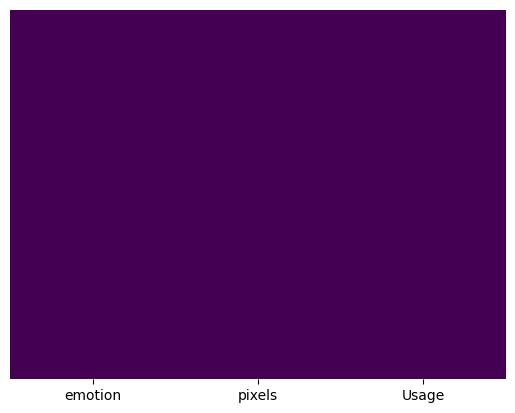

In [ ]:
## Checking for presence of NULL values

sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis') # no null values

In [ ]:
emotions_mapping_dict = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprize", 6:"Neutral"}

In [ ]:
value_counts_emotions = (df.groupby(by='emotion').count())
value_counts_emotions['class'] = [i for i in emotions_mapping_dict.values()]
value_counts_emotions.rename(columns={'pixels': 'count'}, inplace=True)
value_counts_emotions.drop(columns='Usage', inplace=True)
value_counts_emotions

,count,class
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprize
6,6198,Neutral


In [ ]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
def show_images(df, num_images):

    plt.figure(figsize=(15,15))

    random_idxs = np.random.randint(low=0, high=len(df), size=num_images)

    for count,i in enumerate(random_idxs, start=1):
        current_img = np.array([j for j in  df['pixels'][i].split()], dtype='float')  # coz the pixels are space seperated
        current_img = current_img.reshape(48, 48)
        ax = plt.subplot(4, 4, count)
        plt.imshow(current_img, cmap='gray')
        plt.title(emotions_mapping_dict[df['emotion'][i]])
        plt.axis("off")

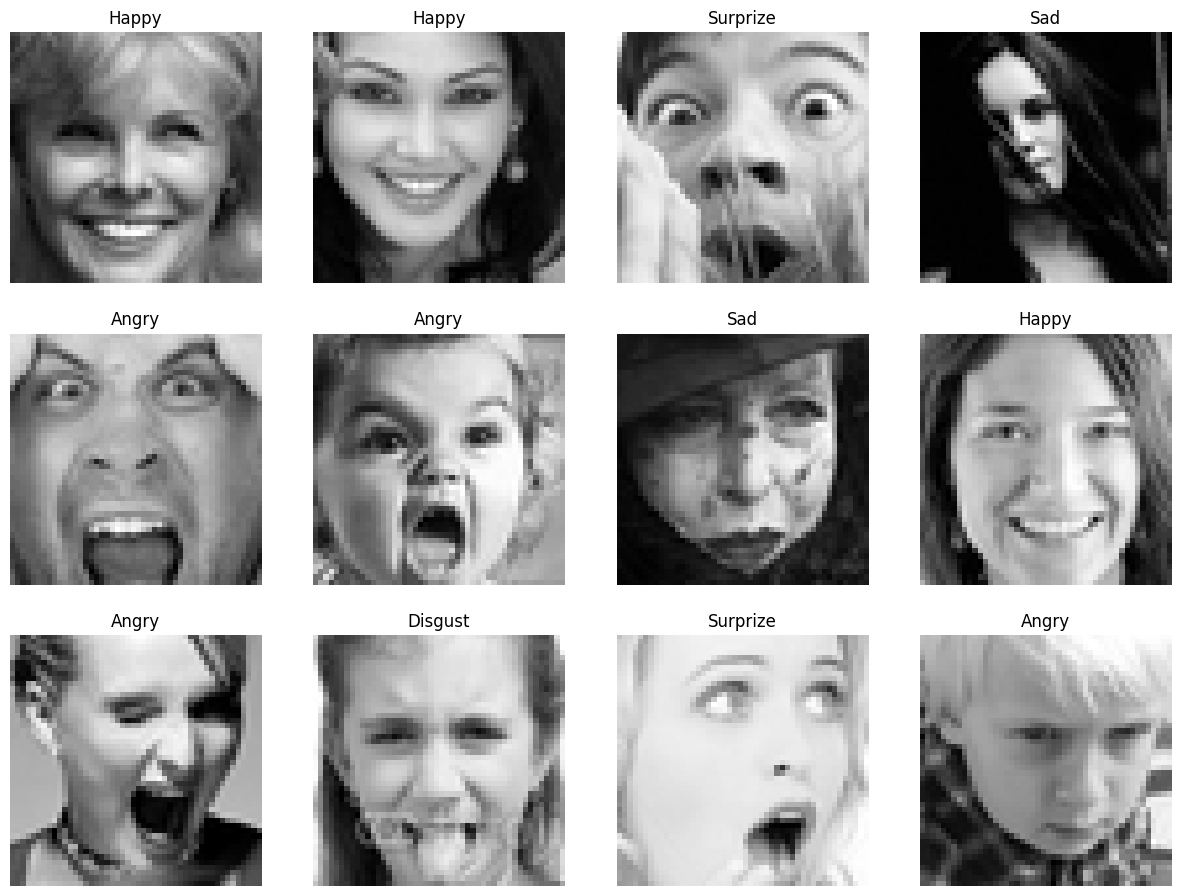

In [ ]:
show_images(df=df, num_images=12)

## Preprocessing

In [ ]:
# Preparing data compatible for creating a HuggingFace dataset
def preprocess_data_1(df):
    images = []

    for count, i in enumerate(df.index):
        current_img = np.fromstring(df.loc[i, 'pixels'], sep=' ', dtype=int)
        images.append(list(current_img))

    return pd.DataFrame({'image':images, 'label':list(df['emotion'])})

In [ ]:
train_df = preprocess_data_1(df=df[df['Usage']=='Training'])
validation_df = preprocess_data_1(df=df[df['Usage']=='PublicTest'])
test_df = preprocess_data_1(df=df[df['Usage']=='PrivateTest'])

In [ ]:
train_df.head()

,image,label
0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",0
1,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",0
2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",2
3,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4
4,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",6


In [ ]:
train_data = Dataset.from_pandas(train_df)
validation_data = Dataset.from_pandas(validation_df)
test_data = Dataset.from_pandas(test_df)

In [ ]:
train_data

Dataset({
    features: ['image', 'label'],
    num_rows: 28709
})

In [ ]:
np.array(train_data[0]['image']).shape  # next, we need to change the space of the images to (48,48,3)

(2304,)

In [ ]:
def preprocess_data_2(example):
    current_img = np.array(example['image'])
    current_img = np.expand_dims(current_img.reshape(48, 48), axis=-1)  # coz we are replacting the single channel 3 times to create a rgb image (ConvNeXT requires rgb images)
    current_img = np.concatenate((current_img, current_img, current_img), axis=-1)
    example['image'] = list(current_img)
    return example

In [ ]:
features = Features({'label': ClassLabel(names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']),
                     'image': Image(decode=True)
                   })

updated_train_data = train_data.map(preprocess_data_2, features=features)
updated_validation_data = validation_data.map(preprocess_data_2, features=features)
updated_test_data = test_data.map(preprocess_data_2, features=features)

  0%|          | 0/28709 [00:00<?, ?ex/s]

  0%|          | 0/3589 [00:00<?, ?ex/s]

  0%|          | 0/3589 [00:00<?, ?ex/s]

In [ ]:
updated_train_data

Dataset({
    features: ['label', 'image'],
    num_rows: 28709
})

In [ ]:
np.array(updated_train_data[0]['image']).shape  # working

(48, 48, 3)

In [ ]:
from datasets import DatasetDict

dataset_dict = DatasetDict({
              "train": updated_train_data,
              "publicTest": updated_validation_data,
              "privateTest": updated_test_data})

In [ ]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 28709
    })
    publicTest: Dataset({
        features: ['label', 'image'],
        num_rows: 3589
    })
    privateTest: Dataset({
        features: ['label', 'image'],
        num_rows: 3589
    })
})

In [ ]:
dataset_dict.push_to_hub("fer2013_train_publicTest_privateTest")

  0%|          | 0/29 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/29 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

## Loading the already pushed dataset from HuggingFace

In [ ]:
dataset = load_dataset("Aaryan333/fer2013_train_publicTest_privateTest")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating privateTest split:   0%|          | 0/3589 [00:00<?, ? examples/s]

Generating publicTest split:   0%|          | 0/3589 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/28709 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Aaryan333___parquet/Aaryan333--fer2013_train_publicTest_privateTest-e8ede1bb0e4b4d61/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    privateTest: Dataset({
        features: ['label', 'image'],
        num_rows: 3589
    })
    publicTest: Dataset({
        features: ['label', 'image'],
        num_rows: 3589
    })
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 28709
    })
})

In [ ]:
dataset["train"]

Dataset({
    features: ['label', 'image'],
    num_rows: 28709
})

In [ ]:
dataset["train"].features

{'label': ClassLabel(names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], id=None),
 'image': Image(decode=True, id=None)}

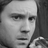

In [ ]:
example = dataset["train"][0]
example["image"]

In [ ]:
example["label"]

0

In [ ]:
class_labels = dataset["train"].features["label"].names
print(class_labels)

['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


In [ ]:
id2label = {k:v for k,v in enumerate(class_labels)}
label2id = {v:k for k,v in enumerate(class_labels)}

## ConvNeXT Preprocessing

In [ ]:
feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")

In [ ]:
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



In [ ]:
from torchvision.transforms import Compose, Normalize, Resize, RandomHorizontalFlip, RandomRotation, RandomAffine, ToTensor
from torchvision.transforms.v2 import RandomZoomOut

In [ ]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)  # normalize the color channels wrt to the imagenet mean and std

transform = Compose(
    [
     Resize(feature_extractor.size['shortest_edge']),  # ConvNeXT needs images of this size
     RandomHorizontalFlip(p=0.5),
     RandomRotation(degrees=20),
     RandomAffine(degrees=0, translate=(0.2, 0.2)),  # does both width_shift_range and height_shift_range
     ToTensor(),  # so PIL to Tensor
     normalize
    ]
)

In [ ]:
def transforms(examples):
    examples["pixel_values"] = [transform(img.convert("RGB")) for img in examples["image"]]

    return examples

In [ ]:
processed_dataset = dataset.with_transform(transforms)  # applies transforms on the fly when in use only, doesn't apply the transform beforehand and save in memory!

In [ ]:
processed_dataset["train"][0]["pixel_values"].shape  # sanity check

torch.Size([3, 224, 224])

In [ ]:
processed_dataset["train"][0]  # pixel_values will be loaded on fly

{'label': 0,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=48x48 at 0x7F38ACE60640>,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [ 0.1254,  0.2453,  0.4166,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179,  0.4166,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [ 0.2577,  0.3803,  0.5553,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357,  0.5553,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0

## Model Creation and Training

In [ ]:
model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224", num_labels=len(class_labels), id2label=id2label, label2id=label2id,
                                                                        ignore_mismatched_sizes=True)

# we use ignore_mismatched_sizes=True coz "facebook/convnext-tiny-224" is already a fine-tuned model which has a classification head. By giving this param, we tell the
#model to ignore this classification head and instead create a new one with 'lables' no. of classes in the classification head.

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    output_dir="./results",
    remove_unused_columns=False,
    num_train_epochs=15,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=5e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs'
)

# remove_unused_columns=False. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop
#unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular)
#in order to create 'pixel_values'.

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
model

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(model=model, args=args, train_dataset=processed_dataset['train'], eval_dataset=processed_dataset['publicTest'], compute_metrics=compute_metrics,
                  data_collator=collate_fn)

## Training

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.080832,0.590137
2,1.238900,0.985399,0.628587
3,0.960800,0.936124,0.652828
4,0.868200,0.924594,0.654778
5,0.795000,0.911840,0.662023
6,0.734800,0.886903,0.674561
7,0.671500,0.884696,0.681806
8,0.625600,0.875780,0.689607
9,0.584100,0.883426,0.692951
10,0.584100,0.906529,0.690164


TrainOutput(global_step=6735, training_loss=0.6725513936859108, metrics={'train_runtime': 2487.3483, 'train_samples_per_second': 173.13, 'train_steps_per_second': 2.708, 'total_flos': 1.0822336036665108e+19, 'train_loss': 0.6725513936859108, 'epoch': 15.0})

## Pushing the Model to the Hub

In [ ]:
repo_name = "convnext-tiny-finetuned-fer2013"

model.push_to_hub(repo_name)
feature_extractor.push_to_hub(repo_name)

pytorch_model.bin:   0%|          | 0.00/111M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Aaryan333/convnext-tiny-finetuned-fer2013/commit/f464292b79b13f196e050de5c8885a7ef929bb1d', commit_message='Upload feature extractor', commit_description='', oid='f464292b79b13f196e050de5c8885a7ef929bb1d', pr_url=None, pr_revision=None, pr_num=None)

## Evaluation

In [ ]:
test_outputs = trainer.predict(processed_dataset['privateTest'])

In [ ]:
test_outputs

PredictionOutput(predictions=array([[ 3.4215999 ,  0.39464462,  1.5265913 , ...,  0.37000477,
        -2.2049274 , -0.01017316],
       [-1.062697  , -2.9954846 ,  0.82805395, ...,  2.8523629 ,
        -1.1592191 , -0.23201647],
       [-1.1158327 , -3.1007376 ,  3.5020866 , ...,  1.8735079 ,
        -1.7236975 ,  0.84790784],
       ...,
       [ 2.0687773 ,  0.0825838 ,  1.4478852 , ...,  2.5138538 ,
        -1.5279204 , -1.6298165 ],
       [-1.2910295 , -3.8112457 , -2.2493255 , ..., -0.9458486 ,
        -0.5339809 ,  1.2627048 ],
       [ 0.82142323, -3.395831  ,  3.4120605 , ...,  2.8047228 ,
        -2.123752  ,  0.05007783]], dtype=float32), label_ids=array([0, 5, 6, ..., 0, 3, 2]), metrics={'test_loss': 0.8750568628311157, 'test_accuracy': 0.694901086653664, 'test_runtime': 11.8597, 'test_samples_per_second': 302.621, 'test_steps_per_second': 4.806})

In [ ]:
print(test_outputs.metrics)

{'test_loss': 0.8750568628311157, 'test_accuracy': 0.694901086653664, 'test_runtime': 11.8597, 'test_samples_per_second': 302.621, 'test_steps_per_second': 4.806}


In [ ]:
y_test = test_outputs.label_ids
test_predictions = test_outputs.predictions.argmax(axis=1)

In [ ]:
target_classes=[]

for i in emotions_mapping_dict.values():
    target_classes.append(i)

In [ ]:
#test data's metrics

print(confusion_matrix(y_test, test_predictions))
print('\n')
macroF1 = precision_recall_fscore_support(y_test, test_predictions, average='macro')
microF1 = precision_recall_fscore_support(y_test, test_predictions, average='micro')
print("Marco Precision Recall & F1 Scores: {}".format(macroF1))
print("Micro Precision Recall & F1 Scores: {}".format(microF1))
print("\n")
print(classification_report(y_test, test_predictions, target_names=target_classes))

[[273   6  61  17  82  11  41]
 [ 10  36   3   1   3   0   2]
 [ 52   2 252   8 116  48  50]
 [ 10   0  15 779  25  14  36]
 [ 29   2  59  15 392   6  91]
 [  6   1  49  19   5 319  17]
 [ 18   0  33  21 104   7 443]]


Marco Precision Recall & F1 Scores: (0.6957037805244417, 0.6726411429029697, 0.6812815717799647, None)
Micro Precision Recall & F1 Scores: (0.694901086653664, 0.694901086653664, 0.694901086653664, None)


              precision    recall  f1-score   support

       Angry       0.69      0.56      0.61       491
     Disgust       0.77      0.65      0.71        55
        Fear       0.53      0.48      0.50       528
       Happy       0.91      0.89      0.90       879
         Sad       0.54      0.66      0.59       594
    Surprize       0.79      0.77      0.78       416
     Neutral       0.65      0.71      0.68       626

    accuracy                           0.69      3589
   macro avg       0.70      0.67      0.68      3589
weighted avg       0.70      0.69

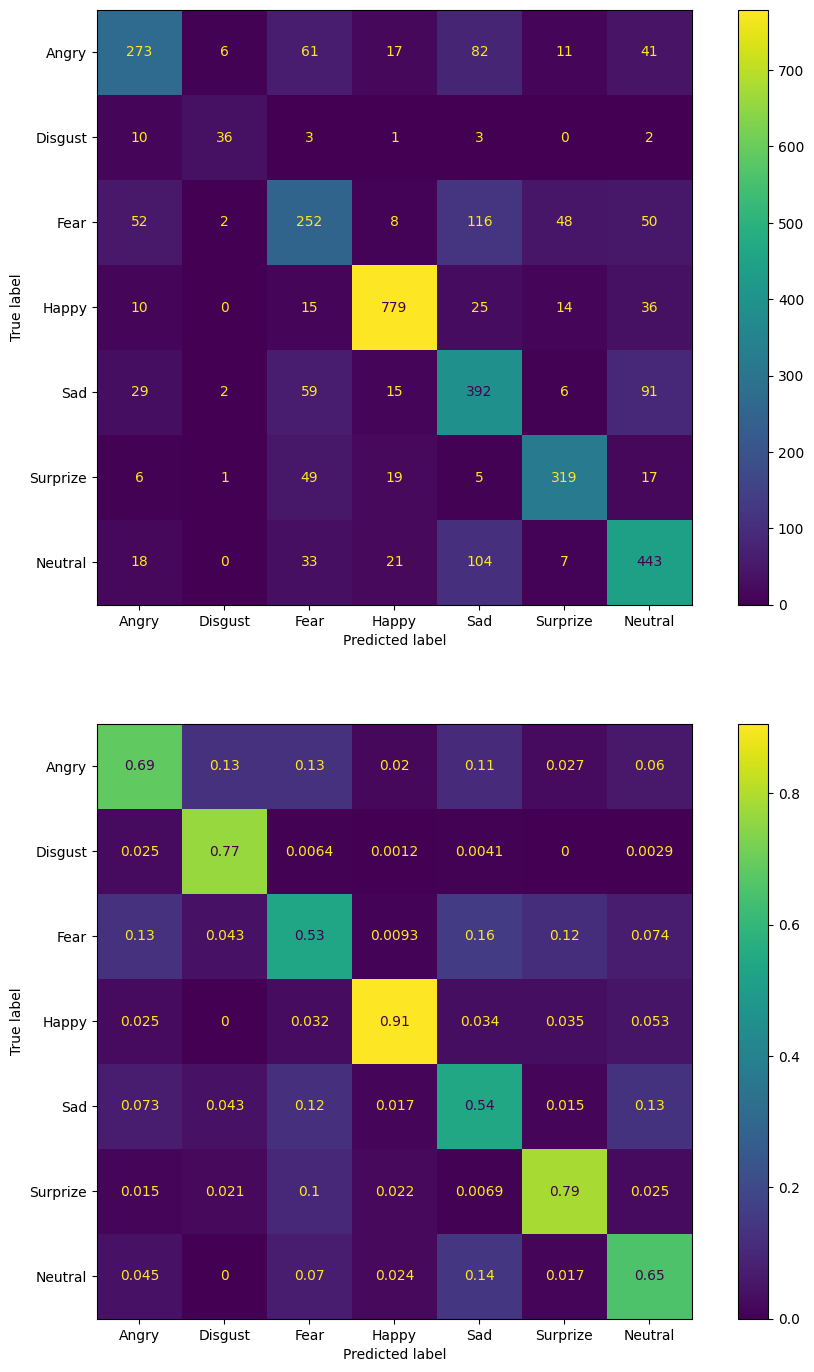

In [ ]:
#plotting the confusion matrix for validation data:

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,17))
cm_plot_1 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=target_classes)
cm_plot_2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions, normalize='pred'), display_labels=target_classes)
cm_plot_1.plot(ax=ax1)
cm_plot_2.plot(ax=ax2)

plt.show()

## API Inferencing

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, pipeline

feature_extractor = AutoFeatureExtractor.from_pretrained("Aaryan333/convnext-tiny-finetuned-fer2013")
model = AutoModelForImageClassification.from_pretrained("Aaryan333/convnext-tiny-finetuned-fer2013")

In [ ]:
pipe = pipeline("image-classification", model=model, feature_extractor=feature_extractor)

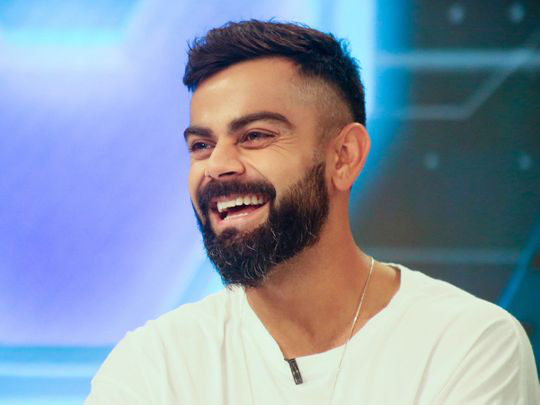

In [ ]:
from PIL import Image
import requests

url = "https://imagevars.gulfnews.com/2019/11/05/Virat-Kohli_16e3b71e549_medium.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
pipe(image)

[{'score': 0.725937008857727, 'label': 'Happy'},
 {'score': 0.14898891746997833, 'label': 'Angry'},
 {'score': 0.07217143476009369, 'label': 'Neutral'},
 {'score': 0.021165557205677032, 'label': 'Sad'},
 {'score': 0.017043063417077065, 'label': 'Surprise'}]